In [1]:
# Model Experiments - Features Sets

# Model - Logistic Reg, Log Loss + Elastic Regularisation + SGD
# Features -
#     * All Channels - Raw, Abs, Mag (8)
#     * All Windows  - 0
#     * All Indiv    - nil
#     * All Pairwise -
#            - Synch - Correl, lag-Correl, MI, mimicry, Coherence and Granger's
#            - Convr - Sym.Conv, Asym.Conv, Glob.Conv
#     * All GroupFeat-
#            - Aggreagtion - Min, Max, Mean, Mode, Var
#            
# Evaluation - Acc, Conf.Matrix, AUC, Precision, Recall,

In [2]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [3]:
from modeling import dataset_provider as data_gen
from feature_extract import turntake_extractor as tt_extractor
import feature_namer_script as feat_namers
import constants

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, mean_squared_error, roc_auc_score, r2_score, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, chi2
from lightgbm import LGBMClassifier
from imblearn import under_sampling 
from imblearn import over_sampling
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy import stats
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew inst

In [4]:
# Variables for baseline
random_seed=44
manifest="group"
data_split_per=.40
missing_data_thresh=50.0 #(in percent)
convq_thresh=3.0
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
only_involved_pairs=True
use_tt_features=False
splits = 5
store_file=constants.indiv_tt_X_path
if manifest=="group":
    smote_nn = 2
    tt_features = ["var_#turn", "var_dturn", "conv_eq", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]
else:
    smote_nn = 6
    tt_features = ["conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]


label_type = "hard"
model_type = "log-elastic"
feat_sel = "lgbc"
zero_mean  = False

datasets=[constants.features_dataset_path_v7,
          constants.features_dataset_path_v13,
          "tt-manifest"]
dataset_feat=[feat_namers.get_feature_names_for_dataset_7,
              feat_namers.get_feature_names_for_dataset_13,
              feat_namers.get_feature_names_for_tt]

In [5]:
# Functions 
def over_sample_data(temp_X, temp_y, method="SMOTE", k_neighbors=6):
    if method == "SMOTE":
        temp_X, temp_y = SMOTE(k_neighbors=k_neighbors-1, random_state=random_seed).fit_resample(temp_X, temp_y)
    return temp_X, temp_y

def feature_normalize(temp_X, method="min-max"):
    # Fit on training set only.
    if method == "min-max":
        normaliser = MinMaxScaler().fit(temp_X)
    elif method == "mean-var":
        normaliser = StandardScaler().fit(temp_X)
    return normaliser
    
def feature_selection(temp_X, temp_y, method="anova", num_feats=None):
    top_features = []
    if method == "anova":
        f_values, p_values = f_classif(temp_X, temp_y)
        threshold=np.median(np.absolute(np.array(f_values)))*num_feats
        top_features=np.where(np.absolute(np.array(f_values)) >= threshold)[0]
#         top_features=np.where(np.absolute(np.array(p_values)) <= 0.5)[0]
    elif method == "tree-based":
        sel_model = SelectFromModel(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                                    max_features=num_feats, threshold=-np.inf).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)
    elif method == "rec-elim":
        sel_model = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'),
                        n_features_to_select=num_feats, step=10000).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)
    elif method == "lgbc":
        lgbc = LGBMClassifier(n_estimators=1000, learning_rate=0.05)
        sel_model = SelectFromModel(lgbc, max_features=num_feats, threshold=-np.inf).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)

    return top_features

def select_required_features(temp_X, required_feats, method="anova"):
    if method == "anova":
        temp_X=temp_X[:,required_feats]
#     elif method
    return temp_X

def dimension_reduction(temp_X, method="pca", threshold_var=0.95):
    dim_red_model = None
    if method=="pca":
        dim_red_model = PCA(threshold_var).fit(temp_X)
    elif method=="tsne":
        dim_red_model = TSNE(n_components=2).fit(temp_X)
    return dim_red_model
    
def process_convq_labels(y, label_type="soft"):
    print("Data-type of labels - " + str(type(y)))
    if label_type=="soft":
        y=list(np.around(np.array(y),2))
    else:
        y=list(np.where(np.array(y) <= convq_thresh, 0, 1))
        print("ConvQ Classes Distribution : (Total = "+ str(len(y)) +")")
        print("High Quality Conv = " + str(sum(y)))
        print("Low Quality Conv = " + str(len(y)-sum(y)))
    return y

def model_convq_manifestation(temp_X, temp_y, model="log-reg", fit=True):
    
    if fit:
        if model == "log-reg":
            model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced').fit(temp_X, temp_y)
        elif model == "lin-reg":
            model = LinearRegression().fit(temp_X, temp_y)
        elif model == "adaboost":
            model = AdaBoostClassifier(n_estimators=500).fit(temp_X, temp_y)
        elif model == "dec-tree":
            model = DecisionTreeClassifier(class_weight='balanced').fit(temp_X, temp_y)
        elif model == "rand-for":
            model = RandomForestClassifier(n_estimators=1000, class_weight='balanced').fit(temp_X, temp_y)
        elif model == "svm":
            model = SVC(kernel='poly').fit(temp_X, temp_y)
        elif model == "log-elastic":
            model = SGDClassifier(loss="log", class_weight="balanced", penalty="elasticnet",
                                  learning_rate='adaptive', eta0=0.001,
                                  max_iter=10000).fit(temp_X, temp_y)
        elif model == "grad-boost-quant":
            model = GradientBoostingRegressor(loss='quantile',n_estimators=1000).fit(temp_X, temp_y)
    else:
        if model == "log-reg":
            model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
        elif model == "lin-reg":
            model = LinearRegression()
        elif model == "adaboost":
            model = AdaBoostClassifier(n_estimators=500)
        elif model == "dec-tree":
            model = DecisionTreeClassifier(class_weight='balanced')
        elif model == "rand-for":
            model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
        elif model == "svm":
            model = SVC(kernel='poly')
        elif model == "log-elastic":
            model = SGDClassifier(loss="log", max_iter=10000, class_weight='balanced')
        elif model == "grad-boost-quant":
            model = GradientBoostingRegressor(loss='quantile',n_estimators=1000)
    return model

def get_model_predict_proba(temp_X, model):
    return model.predict_proba(temp_X)[::,1]

def analyse_model_params(model):
    return True

def test_model(temp_X, model):
    return model.predict(temp_X)

def evaluate_predict(test_temp_y, predict_temp_y, method=accuracy_score):
    score = method(test_temp_y, predict_temp_y)
    return score

In [6]:
# Experiment List
experiments=["Turn-Taking \n Features", "Synchrony \n Features",
             "Convergence \n Features", 
             "Synchrony + \n Convergence",
             "Causality \n Features",
             "Synchrony + \n Convergence \n + Causality \n (Body Coordination)",
             "Turn-Taking + \n Body Coordination", 
             "Turn-Taking + \n Synchrony + \n Convergence"]

In [7]:
# Data Read
auc_experiment_dict={}
X=[]
feat_namer=[]
for w, curr_dataset in enumerate(datasets):
    
    if "tt" in curr_dataset:
        curr_X = tt_extractor.get_tt_dataset_feats_for(ids, tt_features, manifest)
    else:
        curr_X, y, ids = data_gen.get_dataset_for_experiment(dataset=curr_dataset,
                                                            manifest=manifest,
                                                            missing_data_thresh=missing_data_thresh,
                                                            agreeability_thresh=agreeability_thresh,
                                                            annotators=annotators,
                                                            only_involved_pairs=only_involved_pairs,
                                                            zero_mean=zero_mean)
    
    if len(X) == 0:
        X=curr_X
        feat_namer=dataset_feat[w](manifest)
    else:
        X=np.concatenate((X, curr_X), axis=1) 
        feat_namer.extend(dataset_feat[w](manifest))
        
    print("Current Feature Set - " + str(X.shape))
# Label Prep
# Hard/Soft Labels
y = process_convq_labels(y, label_type)

Generating Dataset for modeling - group ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


21it [00:00, 209.93it/s]

Number of Final Data-points (After removing unreliable annotation data) - 58
Dataset for modeling ConvQ Generated !!!!!!


58it [00:00, 128.22it/s]


Total #Features = 756
Current Feature Set - (58, 756)
Generating Dataset for modeling - group ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


58it [00:00, 670.65it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Number of Final Data-points (After removing unreliable annotation data) - 58
Dataset for modeling ConvQ Generated !!!!!!
Total #Features = 126
Current Feature Set - (58, 882)
For Sample ->>>> 1_005


  2%|▏         | 1/58 [00:02<01:58,  2.08s/it]

For Sample ->>>> 1_018


  3%|▎         | 2/58 [00:03<01:46,  1.89s/it]

For Sample ->>>> 1_030


  5%|▌         | 3/58 [00:04<01:32,  1.68s/it]

For Sample ->>>> 1_033


  7%|▋         | 4/58 [00:06<01:25,  1.59s/it]

For Sample ->>>> 1_034


  9%|▊         | 5/58 [00:08<01:29,  1.70s/it]

For Sample ->>>> 1_035


 10%|█         | 6/58 [00:09<01:24,  1.63s/it]

For Sample ->>>> 1_047


 12%|█▏        | 7/58 [00:10<01:08,  1.34s/it]

For Sample ->>>> 1_060


 14%|█▍        | 8/58 [00:11<01:02,  1.25s/it]

For Sample ->>>> 1_061


 16%|█▌        | 9/58 [00:12<01:00,  1.24s/it]

For Sample ->>>> 1_062


 17%|█▋        | 10/58 [00:14<01:08,  1.43s/it]

For Sample ->>>> 1_066


 19%|█▉        | 11/58 [00:15<01:03,  1.35s/it]

For Sample ->>>> 1_067


 21%|██        | 12/58 [00:16<01:01,  1.34s/it]

For Sample ->>>> 1_068


 22%|██▏       | 13/58 [00:18<01:06,  1.47s/it]

For Sample ->>>> 1_069


 24%|██▍       | 14/58 [00:19<00:56,  1.28s/it]

For Sample ->>>> 1_071


 26%|██▌       | 15/58 [00:21<01:03,  1.47s/it]

For Sample ->>>> 1_073


 28%|██▊       | 16/58 [00:21<00:51,  1.23s/it]

For Sample ->>>> 1_075


 29%|██▉       | 17/58 [00:22<00:44,  1.08s/it]

For Sample ->>>> 1_076


 31%|███       | 18/58 [00:23<00:38,  1.05it/s]

For Sample ->>>> 1_077


 33%|███▎      | 19/58 [00:24<00:33,  1.15it/s]

For Sample ->>>> 1_079


 34%|███▍      | 20/58 [00:24<00:30,  1.23it/s]

For Sample ->>>> 1_080


 36%|███▌      | 21/58 [00:25<00:28,  1.31it/s]

For Sample ->>>> 1_081


 38%|███▊      | 22/58 [00:26<00:26,  1.37it/s]

For Sample ->>>> 1_082


 40%|███▉      | 23/58 [00:26<00:26,  1.33it/s]

For Sample ->>>> 1_083


 41%|████▏     | 24/58 [00:27<00:26,  1.30it/s]

For Sample ->>>> 1_084


 43%|████▎     | 25/58 [00:28<00:25,  1.29it/s]

For Sample ->>>> 1_085


 45%|████▍     | 26/58 [00:29<00:25,  1.24it/s]

For Sample ->>>> 1_086


 47%|████▋     | 27/58 [00:30<00:31,  1.02s/it]

For Sample ->>>> 1_087


 48%|████▊     | 28/58 [00:32<00:34,  1.16s/it]

For Sample ->>>> 1_088


 50%|█████     | 29/58 [00:33<00:30,  1.04s/it]

For Sample ->>>> 1_089


 52%|█████▏    | 30/58 [00:34<00:29,  1.06s/it]

For Sample ->>>> 1_090


 53%|█████▎    | 31/58 [00:34<00:25,  1.04it/s]

For Sample ->>>> 2_006


 55%|█████▌    | 32/58 [00:37<00:37,  1.45s/it]

For Sample ->>>> 2_009


 57%|█████▋    | 33/58 [00:38<00:31,  1.27s/it]

For Sample ->>>> 2_022


 59%|█████▊    | 34/58 [00:39<00:30,  1.26s/it]

For Sample ->>>> 2_036


 60%|██████    | 35/58 [00:42<00:36,  1.61s/it]

For Sample ->>>> 2_038


 62%|██████▏   | 36/58 [00:43<00:33,  1.50s/it]

For Sample ->>>> 2_056


 64%|██████▍   | 37/58 [00:44<00:28,  1.38s/it]

For Sample ->>>> 2_057


 66%|██████▌   | 38/58 [00:45<00:25,  1.26s/it]

For Sample ->>>> 2_060


 67%|██████▋   | 39/58 [00:48<00:33,  1.76s/it]

For Sample ->>>> 2_064


 69%|██████▉   | 40/58 [00:50<00:32,  1.82s/it]

For Sample ->>>> 2_066


 71%|███████   | 41/58 [00:51<00:26,  1.57s/it]

For Sample ->>>> 2_067


 72%|███████▏  | 42/58 [00:52<00:22,  1.42s/it]

For Sample ->>>> 2_069


 74%|███████▍  | 43/58 [00:52<00:18,  1.21s/it]

For Sample ->>>> 3_006


 76%|███████▌  | 44/58 [00:54<00:17,  1.28s/it]

For Sample ->>>> 3_007


 78%|███████▊  | 45/58 [00:55<00:15,  1.21s/it]

For Sample ->>>> 3_021


 79%|███████▉  | 46/58 [00:56<00:14,  1.19s/it]

For Sample ->>>> 3_029


 81%|████████  | 47/58 [00:58<00:14,  1.30s/it]

For Sample ->>>> 3_031


 83%|████████▎ | 48/58 [00:59<00:12,  1.24s/it]

For Sample ->>>> 3_033


 84%|████████▍ | 49/58 [01:00<00:11,  1.24s/it]

For Sample ->>>> 3_035


 86%|████████▌ | 50/58 [01:02<00:11,  1.48s/it]

For Sample ->>>> 3_041


 88%|████████▊ | 51/58 [01:04<00:12,  1.74s/it]

For Sample ->>>> 3_048


 90%|████████▉ | 52/58 [01:05<00:08,  1.44s/it]

For Sample ->>>> 3_050


 91%|█████████▏| 53/58 [01:06<00:06,  1.24s/it]

For Sample ->>>> 3_051


 93%|█████████▎| 54/58 [01:07<00:04,  1.13s/it]

For Sample ->>>> 3_058


 95%|█████████▍| 55/58 [01:08<00:03,  1.05s/it]

For Sample ->>>> 3_064


 97%|█████████▋| 56/58 [01:08<00:01,  1.03it/s]

For Sample ->>>> 3_065


 98%|█████████▊| 57/58 [01:09<00:00,  1.07it/s]

For Sample ->>>> 3_066


100%|██████████| 58/58 [01:10<00:00,  1.22s/it]

Current Feature Set - (58, 891)
Data-type of labels - <class 'numpy.ndarray'>
ConvQ Classes Distribution : (Total = 58)
High Quality Conv = 55
Low Quality Conv = 3


In [8]:
# print(X.shape)
# print(tt_features)
# print(len(feat_namer))
features_df=pd.DataFrame(np.array(X), columns=feat_namer)

In [9]:
# TT Gather
tt_feats=[]
for f in feat_namer:
    if "tt-" in f or "#un_interupt" in f:
        tt_feats.extend([f])

# Sync Gather
sync_feats=[]
for f in feat_namer:
    if "corr-" in f or "mi-" in f or "mimicry-" in f:
        sync_feats.extend([f])

# Conv Gather
conv_feats=[]
for f in feat_namer:
    if "conv-" in f:
        conv_feats.extend([f])

#Sync + Conv
sync_conv_feats=list(sync_feats)
sync_conv_feats.extend(conv_feats)
        
# Caus Gather
caus_feats=[]
for f in feat_namer:
    if "granger-" in f or "coherence-" in f:
        caus_feats.extend([f])
        
# ALL-Sync Gather
all_sync_feats=list(sync_feats)
all_sync_feats.extend(conv_feats)
all_sync_feats.extend(caus_feats)

# Fuse Gather
fused_feats=list(all_sync_feats)
fused_feats.extend(tt_feats)

# TT + Sync + Conv Gather
b3_feats=list(sync_feats)
b3_feats.extend(conv_feats)
b3_feats.extend(tt_feats)
 
print("Number of Turn-Taking Features = " + str(len(tt_feats)))
print("Number of Synchrony Features = " + str(len(sync_feats)))
print("Number of Convergence Features = " + str(len(conv_feats)))
print("Number of Synchrony + Convergence Features = " + str(len(sync_conv_feats)))

print("Number of Causality Features = " + str(len(caus_feats)))

print("Number of Coordination Features = " + str(len(all_sync_feats)))

print("Number of Fused Features = " + str(len(fused_feats)))
print("Number of Best 3 = " + str(len(b3_feats)))


feat_stack=[tt_feats,
            sync_feats,
            conv_feats,
            sync_conv_feats,
            caus_feats,
            all_sync_feats,
            fused_feats,
            b3_feats]

print(len(feat_stack))
print(len(experiments))

Number of Turn-Taking Features = 9
Number of Synchrony Features = 588
Number of Convergence Features = 168
Number of Synchrony + Convergence Features = 756
Number of Causality Features = 126
Number of Coordination Features = 882
Number of Fused Features = 891
Number of Best 3 = 765
8
8




~~ !! @@ @@ @@ @@ Current Feature-Set = Turn-Taking 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 5)
After lgbc Feature Set - (38, 5)
Train Data -> Features - (72, 5) and Labels - 72
Test  Data -> Features - (20, 5) and Labels - 20
36
After PCA Feature Set - (39, 6)
After lgbc Feature Set - (39, 5)
Train Data -> Features - (74, 5) and Labels - 74
Test  Data -> Features - (19, 5) and Labels - 19
37
After PCA Feature Set - (39, 5)
After lgbc Feature Set - (39, 5)
Train Data -> Features - (74, 5) and Labels - 74
Test  Data -> Features - (19, 5) and Labels - 19
37


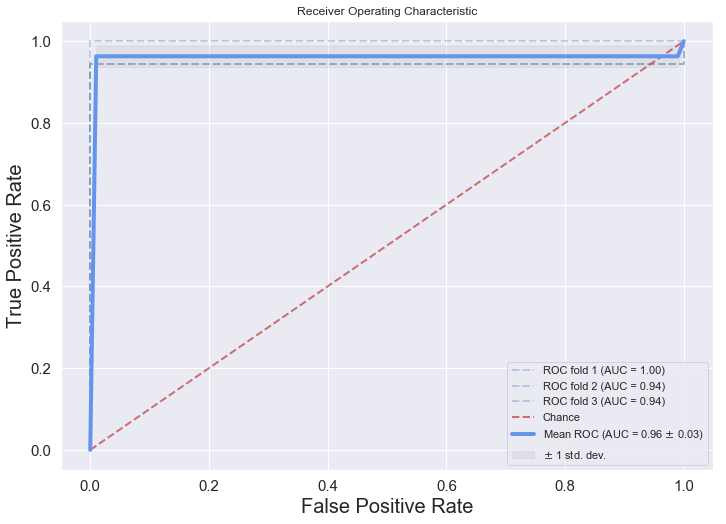

[1.0, 0.9444444444444444, 0.9444444444444444]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 2  1]
 [16 39]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Synchrony 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 23)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 24)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 23)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


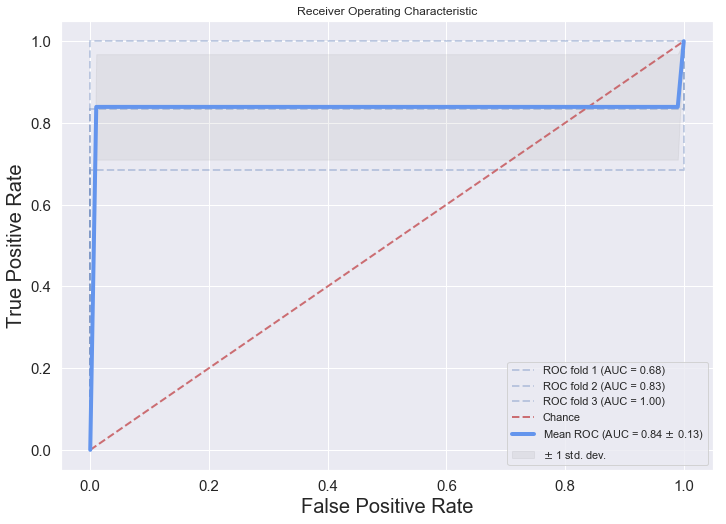

[0.6842105263157895, 0.8333333333333334, 1.0]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 2  1]
 [ 7 48]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Convergence 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 17)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 17)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 17)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


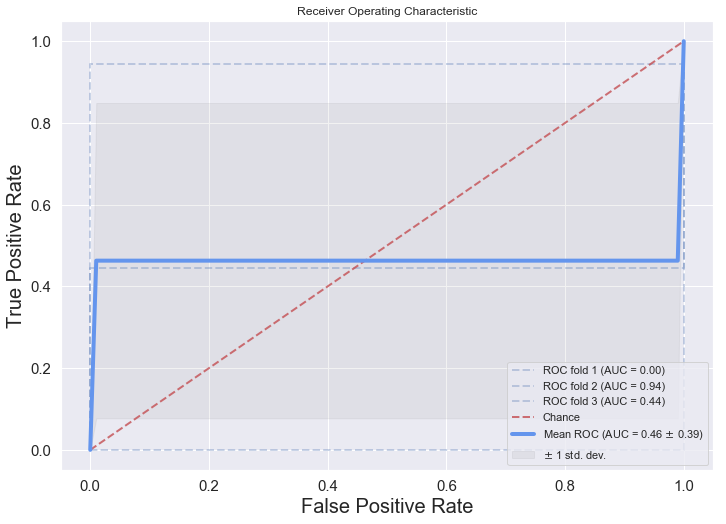

[0.0, 0.9444444444444444, 0.4444444444444444]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 1  2]
 [12 43]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Synchrony + 
 Convergence ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 25)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 26)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 25)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


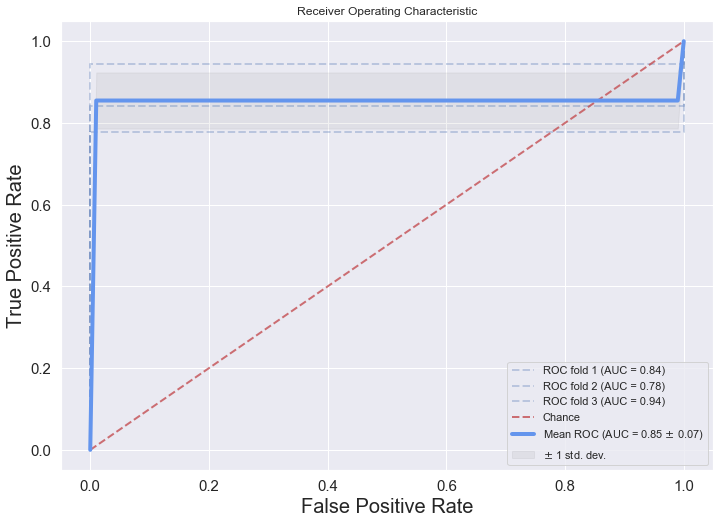

[0.8421052631578947, 0.7777777777777778, 0.9444444444444444]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 2  1]
 [ 7 48]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Causality 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 20)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 20)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 19)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


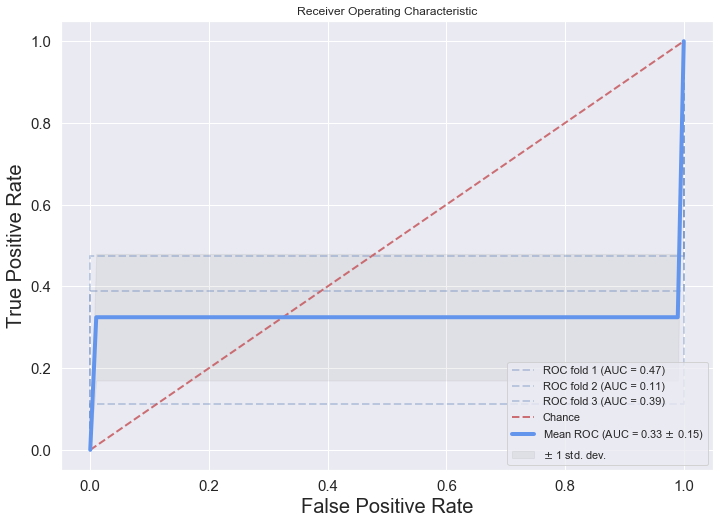

[0.47368421052631576, 0.1111111111111111, 0.3888888888888889]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 0  3]
 [16 39]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Synchrony + 
 Convergence 
 + Causality 
 (Body Coordination) ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 26)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 27)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 27)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


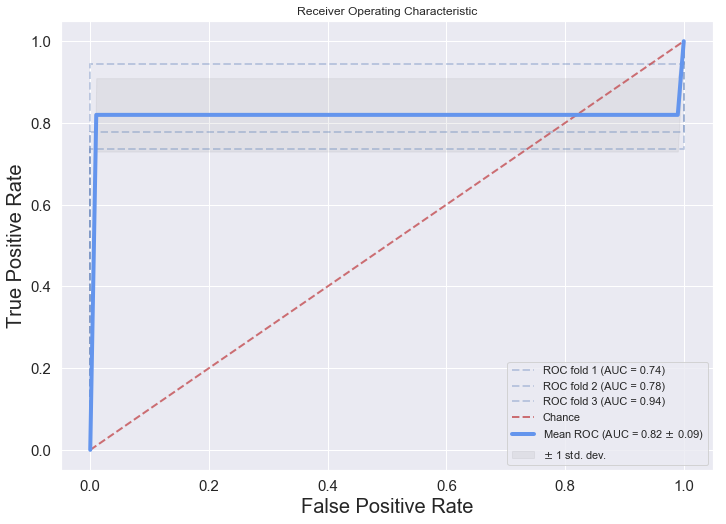

[0.7368421052631579, 0.7777777777777778, 0.9444444444444444]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 2  1]
 [10 45]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Turn-Taking + 
 Body Coordination ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 27)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 27)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 27)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


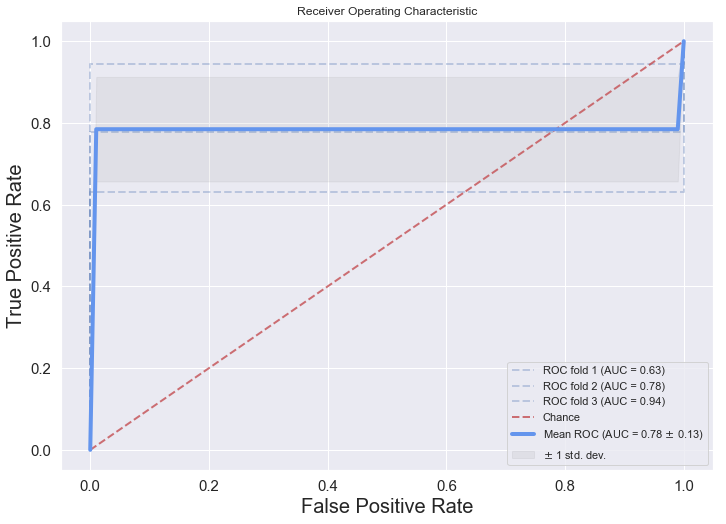

[0.631578947368421, 0.7777777777777778, 0.9444444444444444]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 2  1]
 [ 9 46]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Turn-Taking + 
 Synchrony + 
 Convergence ~~ !! @@ @@ @@ @@
After PCA Feature Set - (38, 25)
After lgbc Feature Set - (38, 16)
Train Data -> Features - (72, 16) and Labels - 72
Test  Data -> Features - (20, 16) and Labels - 20
36
After PCA Feature Set - (39, 26)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37
After PCA Feature Set - (39, 25)
After lgbc Feature Set - (39, 16)
Train Data -> Features - (74, 16) and Labels - 74
Test  Data -> Features - (19, 16) and Labels - 19
37


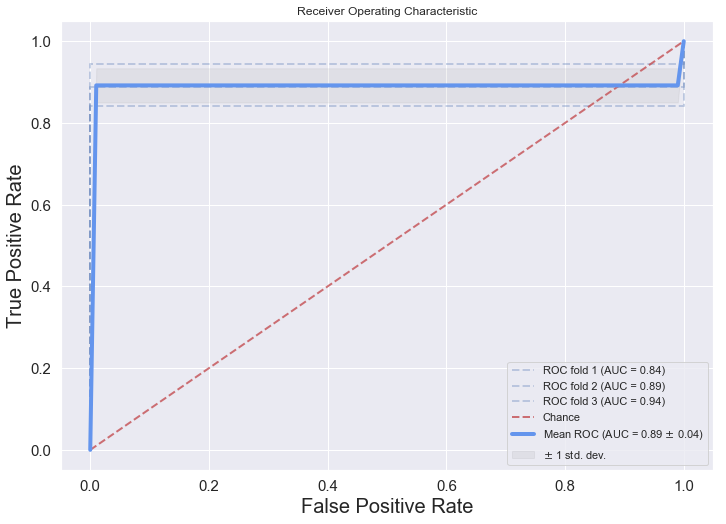

[0.8421052631578947, 0.8888888888888888, 0.9444444444444444]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 2  1]
 [ 8 47]]


In [11]:
feat_sel_threshold=[5, 16, 16, 16, 16, 16, 16, 16]
auc_experiment_dict={}

for f, curr_stack in enumerate(feat_stack):
#     print(features_df)
    experiment_feats=curr_stack
    
    print()
    print()
    print("~~ !! @@ @@ @@ @@ Current Feature-Set = " + str(experiments[f]) + " ~~ !! @@ @@ @@ @@")

    final_conf_matrix = [[0,0],[0,0]]
    final_auc_score = 0.0
    final_r_squared = 0.0
    final_expl_vari = 0.0
    iterative_auc = 0.0
    final_predict = []
    final_pred_prob = []
    final_label = []
    cv_auc_scores = []


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    # Setup Features 
    X=features_df.loc[:,experiment_feats].values
    
    skf = StratifiedKFold(n_splits=3)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):

        # Data Prep
        train_X, test_X  = X[train_index], X[test_index]
        train_y, test_y  = [y[i] for i in train_index], [y[i] for i in test_index]

        # Transform Features
        normaliser = feature_normalize(train_X, method="mean-var")
        # Apply transform to both the training set and the test set.
        train_X = normaliser.transform(train_X)
        test_X  = normaliser.transform(test_X)

        # Dimensionality Reduction
        dimension_model = dimension_reduction(train_X, method="pca")
        train_X = dimension_model.transform(train_X)
        test_X  = dimension_model.transform(test_X)

        print("After " + "PCA" + " Feature Set - " + str(train_X.shape))

        # Feature Selection
        top_features = feature_selection(train_X, train_y, method=feat_sel, num_feats=feat_sel_threshold[f])
        train_X = select_required_features(train_X, top_features) 
        test_X  = select_required_features(test_X, top_features) 

        print("After " + feat_sel + " Feature Set - " + str(train_X.shape))


        # SAMPLING
        train_X, train_y = over_sample_data(train_X, train_y, method="SMOTE", k_neighbors=smote_nn)

        print("Train Data -> Features - " + str(train_X.shape) + " and Labels - " + str(len(train_y)))
        print("Test  Data -> Features - " + str(test_X.shape) + " and Labels - " + str(len(test_y)))
        print(str(sum(train_y))) 

        # Modelling
        classifier         = model_convq_manifestation(train_X, train_y, model_type, fit=True)        
        predict_y          = test_model(test_X, classifier) 


        final_conf_matrix = final_conf_matrix + evaluate_predict(test_y, predict_y, confusion_matrix)

        # CV ROC Plot
        viz = plot_roc_curve(classifier, test_X, test_y,
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=2, linestyle='--', color='b', ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='cornflowerblue',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=4, alpha=1.0)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.tick_params(labelsize=15)
    
    plt.show()

    print(aucs)
    auc_experiment_dict[experiments[f]]=aucs
    print("~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~")
    print(final_conf_matrix)

In [22]:
all_values=[]
all_keys=[]
print(len(auc_experiment_dict.keys()))
print(len(experiments))
for i, k in enumerate(auc_experiment_dict.keys()):
    val=auc_experiment_dict[k]
#     if i !=0:
#         val=[x+.1 for x in val]
    all_values.extend(val)
    text=experiments[i]

    all_keys.extend([text] * 3)

print(len(all_keys))
print(len(all_values))

experiment_results=pd.DataFrame(
    {'values': all_values,
     'type': all_keys
    })


8
8
24
24


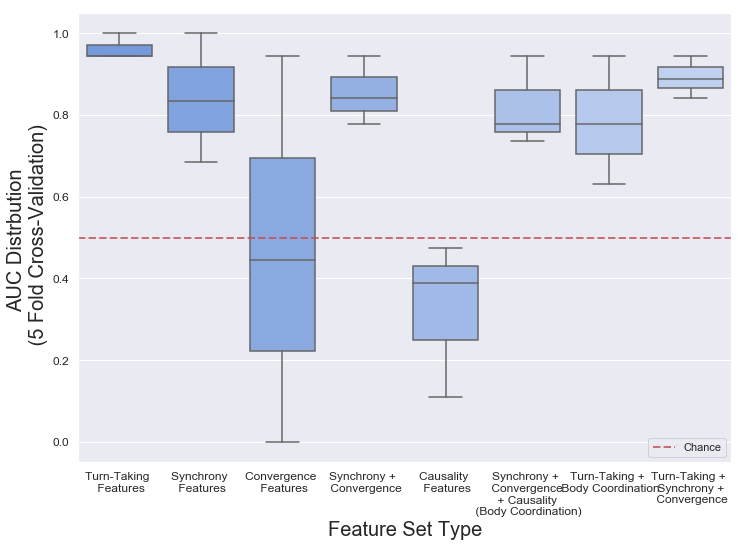

In [23]:
ax = sns.boxplot(x="type", y="values", data=experiment_results, palette=sns.light_palette("cornflowerblue", reverse=True, n_colors=12))

plt.ylabel('AUC Distrbution \n (5 Fold Cross-Validation)', fontsize=20)
plt.xlabel('Feature Set Type', fontsize=20)
plt.tick_params(labelsize=12)

# ax.plot(y=0.5, linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

plt.axhline(0.5, linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Might need to loop through the list if there are multiple lines on the plot
# ax.lines[0].set_linestyle("--")
# plt.plot(0.5)
plt.legend(loc="lower right")


plt.show()